# Using PyMC3 samplers on PyMC4 models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create simple pymc4 model
@pm.model(auto_name=True)
def t_test():
    mu = pm.Normal(0, 1)

model = t_test.configure()

model._forward_context.vars
func = model.make_log_prob_function()

In [4]:
# Create function to evaluate logp and dlogp over array of inputs
@tf.function
def logp_array(array):
    #mu = array[0]
    with tf.GradientTape() as tape:
        tape.watch(array)
        logp = func(array)
    grad = tape.gradient(logp, array)
    
    return logp, grad

In [5]:
# As the above function expects TF inputs and outputs, wrap it as PyMC3's samplers want numpy
def logp_wrapper(array):
    logp, grad = logp_array(tf.convert_to_tensor(array))
    return logp.numpy(), grad.numpy()

In [24]:
q = np.ones(3, dtype='float32')

In [26]:
p = (np.ones(3) * 3).astype(q.dtype)

In [27]:
p


array([3., 3., 3.], dtype=float32)

In [6]:
from pymc4._hmc import HamiltonianMC

In [7]:
size = 1
n_samples = 1000

In [8]:
tf.random.set_seed(123)
np.random.seed(123)
hmc = HamiltonianMC(logp_dlogp_func=logp_wrapper, size=size, adapt_step_size=True)
curr = np.ones(size, dtype='float32') * .05
posterior_samples = []
stats = []

In [9]:
%%time

for i in range(n_samples):
    curr, stat = hmc.step(curr)
    posterior_samples.append(curr)
    stats.append(stat)
    
trace = np.array(posterior_samples)

CPU times: user 1.04 s, sys: 40 ms, total: 1.08 s
Wall time: 946 ms


Compare with `PyMC3`

In [10]:
import pymc3 as pm3

W0412 18:46:07.324292 140225305077504 configdefaults.py:1458] install mkl with `conda install mkl-service`: No module named 'mkl'


In [11]:
with pm3.Model() as model3:
    pm3.Normal('x', 0, 1)

In [12]:
np.random.seed(123)
with model3:
    hmc3 = pm3.HamiltonianMC(adapt_step_size=True)
    
point = {'x': np.array(.05)}
trace3 = []

In [13]:
%%time

for i in range(n_samples):
    point, _ = hmc3.step(point)
    trace3.append(point['x'])

CPU times: user 220 ms, sys: 4 ms, total: 224 ms
Wall time: 219 ms


In [14]:
np.mean(trace), np.mean(trace3)

(-0.0015888748, -0.0011641501922852698)

In [15]:
np.std(trace), np.std(trace3)

(0.9673561, 0.9673307273785291)

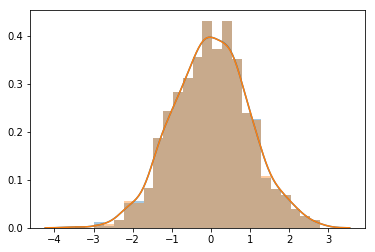

In [16]:
import seaborn as sns
sns.distplot(trace)
sns.distplot(trace3)

There still seems to be a problem here where in the PyMC4 implementation, the step_size keeps getting smaller and smaller, causing the sampler to take very long. Haven't figured it out yet.

In [17]:
hmc.step_size

1.2951355636865856

In [18]:
hmc3.step_size

1.295135672429312

In [19]:
hmc.potential._stds

array([0.97152436])

In [20]:
hmc3.potential._stds

array([0.97152434])